# 基于贝叶斯推理概率伴随法的污染物反演溯源

<div style="color:black; background-color:#FFF3E9; border: 1px solid #FFE0C3; border-radius: 10px; margin-bottom:0rem">
    <p style="margin:1rem; padding-left: 1rem; line-height: 2.5;">
        ©️ <b>Copyright 2023 @ Authors</i></b><br/>
        作者：
            <b>
            <a href="zhhl_email@qq.com"> 张宏亮 📨 </a>
            </b>
        </i>
        <br/>
        日期：2023-08-26</i><br/>

</div>

<p style="color:purple; font-weight:bold">HIGHLIGHT:</p>
<p style="color:purple; font-weight:bold">本文提出一种新模型-“贝叶斯推理伴随概率法”-对城市动态流场环境中潜在的污染源进行反演辨识</p>

<p>基于概率类方法对污染物进行逆向表征：即通过概率方法将污染源逆向表征过程中存在的测量误差和模型误差引入反演过程，最后给出在一定置信度下污染源可能的分布区域以及源特征在某个区域内的概率信息</p>
<div>
    <img src="https://s2.loli.net/2023/08/26/JeRuf6KLISQ8rZ9.png" alt="Fig2" style="zoom: 50%;">
    <p style='font-size:0.8rem; font-weight:bold'>图｜贝叶斯推理概率伴随法示意图</p>
</div>

<div class="alert alert-success">
与用优化法寻找单一的最优值解决源辨识参数估问题不同，本文关注的重点是：在贝叶斯体系下则利用概率工具来解决污染源项的估计问题，将潜在的污染源位置视为概率密度函数在时空内的概率分布，然后通过采样的方式从概率分布中进行统计分析进而得到统计特征。
</div>

<div style="width:auto; height:2px; background:linear-gradient(244deg,rgba(0,0,0,0) 0%,rgba(0,0,0,0.5) 50%,rgba(0,0,0,1) 100%)"></div>

## 目录
* [背景介绍](#layer0)
* [贝叶斯推理与反问题](#layer1)
    * [反问题](#1-1)
    * [贝叶斯推理](#1-2)
* [贝叶斯推理概率伴随法](#layer2)
    * [方法导出](#2-1)
    * [通用控制方程](#2-2)
    * [算法流程](##2-3)
* [FFT-07实验反演应用](#layer3)
    * [计算域定义](#3-1)
    * [动态边界条件](#3-2)
    * [CFD正向结果](#3-3)
* [代码实现](#layer4)
    * [python库导入](#4-1)
    * [函数定义](#4-2)
    * [参数预处理](#4-3)
    * [迭代计算](#4-4)
    * [结果后处理](#4-5)
* [不足及展望](#layer5)    

# 0. 背景介绍<a id='layer0'></a>
截止到2023年，中国的城镇化率已经超过了65%。十四五规划纲要中指出，要全面提升城市品质，增加公共开敞空间，这是因为城市中的公共空间为众多的城市居民提供了重要的活动场所，而城市空间的微环境安全是衡量空间质量的重要因素。拥有健康舒适安全微环境的公共空间可以吸引更多的市民前去活动，增进居民的健康和幸福感，并增加城市的活力，满足“人民日益增长的美好生活需要”。

人居环境中的反问题可视为一个开放复杂的系统，具有多主题、多因素、多尺度、多变性的特征，包含着丰富而深刻的复杂科学问题，且具有大跨度和多学科交叉融合的特点。
城市环境中突发气载污染物的扩散传播对生活在城市中的居民的健康安全产生重大影响，如何对气载污染物的传播路径及释放源进行准确**监控和预测**对为应急人员提供关键情报，以帮助应急决策救援手段的实施具有重要意义。

为对气载污染物的传播路径和范围进行预测，通常需可准确描述气载污染物传播的大气扩散输运模型和气象参数、污染源强度、源位置等参数。其中气象参数可由气象站或观测值获得，而气载污染源的强度、位置、释放规律一般均为未知参数，这对预测气载污染物在城市环境中的传播造成了巨大不确定性。因此，通过布置于城市中的传感器对其突发污染源参数进行辨识属逆向建模问题，并具有强非线性和不适定性，**需要利用各类数学手段求解该病态问题以此重建气载污染物的扩散轨迹和扩散过程。**
<div>
    <img src="https://s2.loli.net/2023/08/26/4vh9JVxRFglKiao.png" alt="Fig2" style="zoom: 50%;">
    <p style='font-size:0.8rem; font-weight:bold'>图｜污染源追溯反演计算问题</p>
</div>

## 1. 贝叶斯推理与反问题<a id='layer1'></a>

### 1.1 反问题<a id='1-1'></a>
对一个物理过程（数学系统）可概括为原因——过程——结果（输入——系统——输出）。正问题表示为已知系统输入和系统运算代求系统输出，而对于反问题或缺系统和输入的任何一环均可表述为反问题求解，图中描述了反问题的发生过程。
<div>
    <img src="https://s2.loli.net/2023/08/26/pyzwL4ngvRsPKUe.png" alt="Fig2" style="zoom: 40%;">
    <p style='font-size:0.8rem; font-weight:bold'>图｜正/反问题</p>
</div>
在科学与工程中反问题普遍存在，人居环境中亦不例外，大部分的正问题及其反问题都是由微分方程进行建模。根据描述人居环境内部流动的控制方程式的特点及反演物理量的类型，应该至少可以有：热物理性质参数辨识估计问题（如扩散项系数）、源追溯问题（如热源、污染源辨识及反向传播）、初边界条件控制问题（如初始条件、边界条件、逆时间）和全局反演拓扑设计（如几何形状）问题等四类。


### 1.2 贝叶斯推理<a id='1-2'></a>
贝叶斯推理方法采用了概率的逻辑来看待污染物逆向表征问题，和传统的统计推理不同，贝叶斯推理是建立在对事件的已有认识基础上保留结果的不确定性，认为概率表示的是客观上事实的可信程度，也可以说成是主观上主体对事件的信任程度。

$$p\left( {M{\rm{|}}D,I} \right) = {{p\left( {M{\rm{|}}I} \right)p\left( {D{\rm{|}}M,I} \right)} \over {P\left( {D{\rm{|}}I} \right)}}$$

对于人居环境中的污染物溯源反问题，$M$代表污染物的未知系统及模型参数；$D$代表环境中各类探测器的观测数据；$I$为可用已知的系统及模型相关信息。$p(M|I)$为代求随机变量参数的先验概率密度函数，先验分布通常为以往的专家经验或者直接进行假设；$p(D|M,I)$为代求系统及模型参数M确定的条件下，模型预测结果拟合观测数据的似然度，即似然函数；$p(M|D,I)$为污染物模型参数的后验概率密度函数，即反演辨识的结果。贝叶斯推理应用在反演人居环境中的污染物时，即通过不断获得观测数据$D$来更新模型参数M的后验概率密度分布，利用贝叶斯推理进行污染物逆向表征的流程如图所示。
<div>
    <img src="https://s2.loli.net/2023/08/26/D6mhVUaiP34RWSs.png" alt="Fig2" style="zoom: 60%;">
    <p style='font-size:0.8rem; font-weight:bold'>图｜贝叶斯反演流程图</p>
</div>


## 2. 贝叶斯推理概率伴随法<a id='layer2'></a>

### 2.1 方法导出<a id='2-1'></a>
正向扩散浓度场C和对偶伴随浓度场$C^*$的示意图如图，表现为监测点作为名义污染源在对偶伴随系统中进行逆向输运扩散，每个监测点在对偶伴随系统作用下均产生一个影响区域。从逆向轨迹方法(Inverse Trajectory Approach) 角度理解，污染源处于影响区域的交叉处（如图中红色区域所示），而Sensor3监测器所产生的影响区域有助于缩小潜在污染源所在区间。该逆向轨迹方法可视为对偶伴随方法的简化使用，但缺乏污染源强度与监测点直接的定量关系。

<div>
    <img src="https://s2.loli.net/2023/08/26/TBOyxdfXKALleiE.png" alt="Fig2" style="zoom: 60%;">
    <p style='font-size:0.8rem; font-weight:bold'>图｜对偶伴随浓度场扩散示意图</p>
</div>

### 2.2 通用控制方程 <a id='2-2'></a>
本文提出了贝叶斯推论概率方法，统一了概率伴随法和对偶伴随贝叶斯推理方法，通过建立通用形式的污染物逆向输运方程利用基于贝叶斯的传统概率法和基于概率伴随的联合概率法完成对街区环境中污染物源信息的反演辨识。该逆向输运方程与其匹配的初边界为：

$$ - {{\partial \Phi } \over {\partial t}} - \vec u \cdot \nabla \Phi  = \nabla  \cdot \left( {D\nabla \Phi } \right) + S$$


$$\left\{ {\begin{array}{*{20}{l}}
{\Phi \left( {\vec x,0} \right) = 0}\\
{\Phi \left( {\vec x,t = T} \right) = 0 \in {\Gamma _1}}\\
{\left( {\vec u\Phi  + D\nabla \Phi } \right) \cdot \vec n = 0 \in {\Gamma _2}}\\
{\left( {D\nabla \Phi } \right) \cdot \vec n = 0 \in {\Gamma _3}}
\end{array}} \right.$$

式中$\Phi$为通用变量，$S$为通用源项。

通过求解通用形式的污染物逆向输运方程，可同时得到概率伴随方程和对偶伴随方程的解，概率伴随法根据式计算得到的UALP (Union standard Adjoint Location Probability-UALP) 区域（如图中灰色区域所示）可作为贝叶斯推理的采样空间。

<div>
    <img src="https://s2.loli.net/2023/08/26/vscBbZVOzAaxqiY.png" alt="Fig2" style="zoom: 60%;">
    <p style='font-size:0.8rem; font-weight:bold'>图｜贝叶斯推理概率伴随法采样示意图</p>
</div>

### 2.3 算法流程<a id='2-3'></a>
本文所提出贝叶斯推理概率伴随法，首先通过先验信息确定先验概率密度函数的形式，然后利用CFD方法求解非稳态形式的污染物逆向输运方程，得到计算域中概率伴随因子 和对偶污染物浓度值$C^*$的分布。通过计算得到的UALP确定建议分布的每步采样值，然后计算似然函数和后验概率分布以判断是否达到收敛标准，如未收敛则进入下一步循环，从建议分布中进行新的采样。

相比于在整个计算区域内进行采样，该方法有效缩小了采样空间的范围，而无需额外增加计算量，以此达到提高采样效率和采样精度的目的。
<div>
    <img src="https://s2.loli.net/2023/08/26/3JqslSvcZX1M9K2.png" alt="Fig2" style="zoom: 60%;">
    <p style='font-size:0.8rem; font-weight:bold'>图｜贝叶斯推理概率伴随法流程图</p>
</div>

可以发现贝叶斯推理概率伴随法与对偶伴随贝叶斯推理法的流程基本相似，主要区别在于由概率伴随方程确定的采样区间，从而减少MCMC的采样范围，提高接受率和准确性，具体的案例分析和不同算法间的对比将在下一节进行研究。


## 3. FFT-07试验反演应用<a id='layer3'></a>

### 3.1 试验简介及计算域<a id='3-1'></a>
美国犹他州的美国陆军Dugway试验场于2007年9月进行了污染物释放的外场实验(Fusing Sensor Information From Observing Networks (FUSION) Field Trial 2007, FFT-07)以获取用于研究的污染物扩散信息，用于验证开发污染物扩散重建模型。关于实验的详细内容可参见 [1]

<div>
    <img src="https://s2.loli.net/2023/08/26/HoPeDgsu1dbrLc7.png" alt="Fig2" style="zoom: 50%;">
    <p style='font-size:0.8rem; font-weight:bold'>图｜FFT-07计算域及及监测点布局</p>
</div>


| NO | 风场状态 |Monin长度| 传感器数 | 位置, m    | 强度, g/s | 风速, m/s |风向, deg |
| :--:|:---:    |     :---:|   :---: |  :---:     | :---:     |     :---:  |   :---: |
| 30 | Stable  |   0.55  |   19    | (651, 322) | 3.43     | 3.22      | -25°    |
  

### 3.2 动态边界条件<a id='3-2'></a>
在真实环境中的风场是动态变化的，污染源的释放规律也可能是时间的函数，风场的变化尤其是风向的实时变化会对寻源结果的准确性和时效性起到决定性作用。目前关于污染源在动态风场或气流组织下的污染源定位研究较为匮乏，大部分学者在研究中忽略了气流组织动态变化对污染源定位的影响。这一假设在室外风场相对稳定或室内空调系统工况稳定时可近似成立，然而当室外风场主导风向变化较大或室内空调处于变工况条件下，动态气流组织下的污染物溯源问题值得进一步研究。FFT-07实验Trial-30工况下在源释放后15分钟统计的风速风向信息如图所示
<div>
    <img src="https://s2.loli.net/2023/08/26/bMxTHLk4ByCQpKZ.png" alt="Fig2" style="zoom: 70%;">
    <p style='font-size:0.8rem; font-weight:bold'>图｜瞬态风场下风向与风速气象数据</p>
</div>

### 3.3 CFD正向计算结果<a id='3-3'></a>
通过CFD方法求解污染物的输运方程，展示在6个时刻 (t=50s，t=100s，t=150s，t=200s，t=250s，t=300s) 处的污染物浓度的分布情况如图，受不断变化的风速和风向的影响，污染物的扩散发展情况变化较大。本章的研究重点为在非稳态的气流下，概率伴随法溯源的可行性，因此将此模拟输入可视为浓度场的实际扩散结果。
<div>
    <img src="https://s2.loli.net/2023/08/26/de6wimy5DqTlBxk.png" alt="Fig2" style="zoom: 20%;">
    <p style='font-size:0.8rem; font-weight:bold'>图｜各时刻污染物在流场中的发展趋势</p>
</div>

## 4. 代码实现<a id='layer4'></a>
<div style="padding: 10px; background-color: #f5f5f5; color: black; margin-bottom: 15px; border-radius: 30px;">
    <p style='padding: 10px'>代码不依赖框架，仅需python>=3.0及基础python库即可完成</b></p>
        <p style='padding-left: 10px; padding-right: 10px;'>自己的时间比电脑是时间更宝贵，比起代码执行效率更注重可读性</p>
</div>

<div style="width:auto; height:2px; background:linear-gradient(244deg,rgba(0,0,0,0) 0%,rgba(0,0,0,0.5) 50%,rgba(0,0,0,1) 100%)"></div>

### 4.1 导入所需依赖库<a id='4-1'></a>

In [1]:
!pip install seaborn --upgrade --quiet
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_bvp
import matplotlib
from scipy.stats import gaussian_kde
import csv
from scipy.interpolate import griddata 
import scipy.stats as stats 
from matplotlib.pyplot import MultipleLocator

### 4.2 定义所需函数<a id='4-2'></a>

In [2]:
# 用于计算似然函数, c_predict和c_true为存储预测点值和检测点值的数组
def likelihood_func_log(sigma, c_predict, c_true):
     #c_predict = data_predict_new
     #sigma = sigma
     #c_true = point_true_value
    return -len(c_true)*np.log(sigma * np.sqrt(2* np.pi)) - np.sum(((c_true-c_predict)**2) / (2*sigma**2))

# 从fluent中导出的数据导入到numpy数组中
def adjoint_file_to_array(sensor_list):

    # 保存x坐标, 和y坐标的列表
    x=[]; y=[]

    # 创建N个二维空数组
    uds = [[] for i in range(len(sensor_list))]
    
    # 创建一维列表，用于存储二维np数组，进而转化为三维np数组
    uds_t = []

    # 读取csv文件，当然也可以读取类似txt之类的文件
    with open(r'/data/DREAM-ULAP/uds_adjoint','r')  as  csvfile:   
        #指定分隔符为","，因为我们刚才导出时就是逗号
        plots=csv.reader(csvfile,delimiter=',')
        #循环读取文件各列
        for row in plots:
            #为了跳过文件前面的非数据行  
            if plots.line_num == 1:
                continue
            # 读取x和y坐标
            x.append(float(row[1]))
            y.append(float(row[2]))
            # 读取uds_1-uds_19的场值到二维数组uds中
            for i in range(len(sensor_list)):
                uds[i].append(float(row[i+3]))
                
    # 将一维列表(元素为一维数组)转化为二维数组             
    uds = np.array(uds)

    # 确定meshgrid的坐标范围，并离散坐标
    xi=np.linspace(min(x),max(x), 5000)
    yi=np.linspace(min(y),max(y), 5000)
     
    # grid_x,grid_y坐标必须维数一致，且为二维
    grid_x, grid_y = np.meshgrid(xi, yi)
     
    # 对x，y位置的浓度值进行插值，插值的方法有'cubic', 'linear', 'nearest'
    # 注意传入的坐标参数需要以元组的形式成对传入
    # 当然matplotlib也自带griddata插值函数，该函数每个坐标是一个参数
    # 但matplotlib自带的griddata插值函数只能使用默认的linear插值

    # griddata插值，并存入uds_t列表中，列表中的元素为二维数组
    for i in range(len(sensor_list)):
        uds_t.append(griddata((x,y), uds[i], (grid_x,grid_y), method='nearest', fill_value = np.nan, rescale = False))

    # 将uds_t转换为三维np数组
    uds_t = np.array(uds_t)
    
    # 保存到文件中，下次使用是直接读取文件，避免重复上述过程(太慢！)
    np.save('uds_adjoint.npy', uds_t)
    plt.contour(grid_x, grid_y, uds_t)
    
def direct_file_to_array(source_list):
    # 保存x坐标, 和y坐标的列表
    x=[]; y=[]

    # 创建N个二维空数组
    uds = [[] for i in range(len(source_list))]
    
    # 创建一维列表，用于存储二维np数组，进而转化为三维np数组
    uds_t = []

    # 读取csv文件，当然也可以读取类似txt之类的文件
    with open(r'/data/DREAM-ULAP/uds_direct','r')  as  csvfile:   
        #指定分隔符为","，因为我们刚才导出时就是逗号
        plots=csv.reader(csvfile,delimiter=',')
        #循环读取文件各列
        for row in plots:
            #为了跳过文件前面的非数据行  
            if plots.line_num == 1:
                continue
            # 读取x和y坐标
            x.append(float(row[1]))
            y.append(float(row[2]))
            # 读取uds_1-uds_6的场值到二维数组uds中
            for i in range(len(source_list)):
                uds[i].append(float(row[i+3]))
                
    # 将一维列表(元素为一维数组)转化为二维数组             
    uds = np.array(uds)
    
    # 确定meshgrid的坐标范围，并离散坐标
    xi=np.linspace(min(x),max(x), 5000)
    yi=np.linspace(min(y),max(y), 5000)
     
    # grid_x,grid_y坐标必须维数一致，且为二维
    grid_x, grid_y = np.meshgrid(xi, yi)
     
    # 对x，y位置的浓度值进行插值，插值的方法有'cubic', 'linear', 'nearest'
    # 注意传入的坐标参数需要以元组的形式成对传入
    # 当然matplotlib也自带griddata插值函数，该函数每个坐标是一个参数
    # 但matplotlib自带的griddata插值函数只能使用默认的linear插值

    # griddata插值，并存入uds_t列表中，列表中的元素为二维数组
    for i in range(len(source_list)):
        uds_t.append(griddata((x,y), uds[i], (grid_x,grid_y), method='nearest', fill_value = np.nan, rescale = False))

    # 将uds_t转换为三维np数组
    uds_t = np.array(uds_t)
    
    # 保存到文件中，下次使用是直接读取文件，避免重复上述过程(太慢！)
    np.save('uds_direct.npy', uds_t)
    plt.contour(grid_x, grid_y, uds_t)
    
# 用于计算伴随浓度场在预测点(X_current, Y_current)处的浓度值
def adjoint_results_1(source_list, sensor_list):
    # 保存源处的伴随浓度值
    point_adjoint_value = [] 
    
    for i in range(len(sensor_list)):
        point_adjoint_value.append(uds_adjoint[i][int(5*source_list[0][1])][int(5*source_list[0][0])])
    # 浓度列表返回
    return np.array(point_adjoint_value)

# 用于计算伴随浓度场在预测点(X_current, Y_current)处的浓度值
def adjoint_results(X_current, Y_current, S_current, sensor_list):
    # 用于存储新预测位置下,各监测点处的值(对偶)
    data_predict_new = []
    
    for i in range(len(sensor_list)):
        data_predict_new.append(S_current*uds_adjoint[i][int(5*Y_current)][int(5*X_current)])
    
    # 返回存储各监测点浓度值的列表
    return data_predict_new

def UALP_area():
    # 保存x坐标, 和y坐标的列表
    x=[]; y=[]

    # 创建1个二维空数组
    uds = [[] for i in range(1)]

    # 创建一维列表，用于存储二维np数组，进而转化为三维np数组
    uds_t = []

    # 读取csv文件，当然也可以读取类似txt之类的文件
    with open(r'/data/DREAM-ULAP/UALP','r')  as  csvfile:   
        #指定分隔符为","，因为我们刚才导出时就是逗号
        plots=csv.reader(csvfile,delimiter=',')
        #循环读取文件各列
        for row in plots:
            #为了跳过文件前面的非数据行  
            if plots.line_num == 1:
                continue
            # 读取x和y坐标
            x.append(float(row[1]))
            y.append(float(row[2]))
            # 读取udm_11的场值到二维数组uds中
            for i in range(1):
                uds[i].append(float(row[i+3]))

    # 将一维列表(元素为一维数组)转化为二维数组             
    uds = np.array(uds)
    
    # # 设置Pt的截断值（阈值）
    for i in range(1):
        for j in range(len(y)):
            if uds[i][j] < 1e-18:
                uds[i][j] =0.

    # 确定meshgrid的坐标范围，并离散坐标
    xi=np.linspace(min(x),max(x), 5000)
    yi=np.linspace(min(y),max(y), 5000)
     
    # grid_x,grid_y坐标必须维数一致，且为二维
    grid_x, grid_y = np.meshgrid(xi, yi)
     
    # 对x，y位置的浓度值进行插值，插值的方法有'cubic', 'linear', 'nearest'
    # 注意传入的坐标参数需要以元组的形式成对传入
    # 当然matplotlib也自带griddata插值函数，该函数每个坐标是一个参数
    # 但matplotlib自带的griddata插值函数只能使用默认的linear插值

    # griddata插值，并存入uds_t列表中，列表中的元素为二维数组
    for i in range(1):
        uds_t.append(griddata((x,y), uds[i], (grid_x,grid_y), method='nearest', fill_value = np.nan, rescale = False))

    # 将uds_t转换为三维np数组
    uds_t = np.array(uds_t)
    uds_t = uds_t[0,:,:]
    # 保存到文件中，下次使用是直接读取文件，避免重复上述过程(太慢！)
    np.save('uds_UALP.npy', uds_t)
    plt.contour(grid_x, grid_y, uds_t)
    
# 用于提取uds_7在监测点处的浓度值(真实值)
def direct_results(sensor_list):  
    # 保存监测点处的真实浓度值
    point_true_value = []
    for i in range(len(sensor_list)):
        point_true_value.append(uds_direct[0][int(5*sensor_list[i][1])][int(5*sensor_list[i][0])])
    # 浓度列表返回
    return point_true_value

# 用于计算在建议点处的UALP
def UALP_result(X_current, Y_current):
    return uds_UALP[int(5*Y_current)][int(5*X_current)]

### 4.3 参数预处理设置<a id='4-3'></a>
设定真实污染源的位置及强度

In [3]:
X_true = 651
Y_true = 322
S_true = 3.43
source_list = [[651, 322]]

设定监测点的坐标

In [4]:
sensor_list = [[302.95, 656.38],
               [438.89, 719.76],
               [346.74, 621.62],
               [392.05, 642.75],
               [437.37, 663.88],
               [390.52, 586.84],
               [435.84, 608.00],
               [481.15, 629.13],
               [434.31, 552.12],
               [479.63, 573.25],
               [478.10, 517.37],
               [523.42, 538.50],
               [521.89, 482.62],
               [520.36, 426.74],
               [565.68, 447.87],
               [564.15, 391.99],
               [609.47, 413.12],
               [607.94, 357.24]]

从fluent导出的ASCII文件重建为python数组，并保存为npy文件，避免重复转换数据

In [5]:
#direct_file_to_array(source_list)
#adjoint_file_to_array(sensor_list)
#UALP_area()

从文件中导入uds_adjoint数组，uds_direct数组，uds_UALP数组

In [6]:
uds_adjoint = []; uds_adjoint = np.load('uds_adjoint.npy', uds_adjoint)
uds_direct = []; uds_direct = np.load('uds_direct.npy', uds_direct)
uds_UALP = []; uds_UALP = np.load('uds_UALP.npy', uds_UALP)

概率伴随场展示

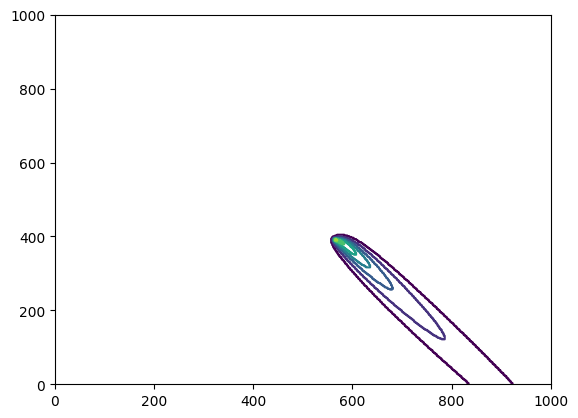

In [7]:
# 确定meshgrid的坐标范围，并离散坐标
xi=np.linspace(0,1000, 5000)
yi=np.linspace(0,1000, 5000)
# grid_x,grid_y坐标必须维数一致，且为二维
grid_x, grid_y = np.meshgrid(xi, yi)
plt.contour(grid_x, grid_y, uds_UALP)

如果真实污染源浓度=伴随浓度场浓度，则说明根据污染物对偶输运方程建立的伴随场准确，可用于贝叶斯推理

In [8]:
point_true_value = S_true * np.array(direct_results(sensor_list))
point_adjoint_value = S_true * adjoint_results_1(source_list, sensor_list)

# 打印真实污染源时监测点处污染物的浓度
for i in range(len(point_true_value)):
    print(f"point_{i+1}_true_value = {point_true_value[i]}") 
    
print('-------------------')
    
for i in range(len(point_adjoint_value)):
    print(f"point_{i+1}_adjoint_value = {point_adjoint_value[i]}") 

point_1_true_value = 0.36949207971200004
point_2_true_value = 0.198062572043
point_3_true_value = 0.47993274263200003
point_4_true_value = 0.778752950738
point_5_true_value = 0.483976643689
point_6_true_value = 0.5881925000770001
point_7_true_value = 0.8100626702210001
point_8_true_value = 0.351331350979
point_9_true_value = 0.750937382888
point_10_true_value = 0.765188964974
point_11_true_value = 0.9326016603539999
point_12_true_value = 0.634661685602
point_13_true_value = 1.100921473771
point_14_true_value = 0.6158626060860001
point_15_true_value = 1.16334168153
point_16_true_value = 0.9777517738660001
point_17_true_value = 0.8711934500849999
point_18_true_value = 1.7760907088890001
-------------------
point_1_adjoint_value = 0.36951377652
point_2_adjoint_value = 0.1908724833862
point_3_adjoint_value = 0.47994700251399997
point_4_adjoint_value = 0.778814130619
point_5_adjoint_value = 0.48401308572400004
point_6_adjoint_value = 0.588191171295
point_7_adjoint_value = 0.810117154399
poi

关键参数设定及变量声明  

In [9]:
n_samples = 50000   # MCMC采样次数
n_chains = 5        # Markov 链的数量
n_dims = 3          # 参数的维度
sigma = 0.05         # 目标分布中似然函数的标准差

X_init = 566    # 用于设定X迭代初始值
Y_init = 390    # 用于设定Y迭代初始值
S_init = 3.43      # 用于设定Y迭代初始值

samples = np.random.rand(n_chains, n_samples, n_dims)  # 每条链的初始点
samples[: , 0, 0] = X_init         # 每条链的初始点
samples[: , 0, 1] = Y_init         # 每条链的初始点
samples[: , 0, 2] = S_init         # 每条链的初始点

trunc_X = [0, 1000]  # 设置建议分布截断范围
trunc_Y = [0, 1000]  # 设置建议分布截断范围
trunc_S = [0, 5]     # 设置建议分布截断范围

gamma = 2.38 / np.sqrt(2 * n_dims)  # 更新规则中的因子
b_star = 1e-12
b = 0.1
epsilon = 1e-6  # 保证生成的提议点与当前点不同的小常数

count = 0       # 用于计算接受率标识
flag = True     # 用于记录是否接受了新值
iteration = np.zeros(n_samples) # 用于计算逐时的接受率
accepted = []  # 记录接受的采样
rejected = []  # 记录拒绝的采样

  0%|          | 0/49999 [00:00<?, ?it/s]/tmp/ipykernel_1321/3583458538.py:68: RuntimeWarning: overflow encountered in exp
  alpha = min(1, np.exp(likelihood_j - likelihood_i))
100%|██████████| 49999/49999 [00:28<00:00, 1758.29it/s]


max_kde_Sa = 3.428616092192429, Euler_distance = 0.7937396157338981



本文所研究的街区环境中的污染物溯源问题是具有多参数、高维度的复杂问题，将采用具有较高的空间探索能力和采样效率的Differential Evolution-MCMC算法
<div>
    <img src="https://s2.loli.net/2023/08/26/zr6O8aleNQZSvcP.png" alt="Fig2" style="zoom: 60%;">
</div>

### 4.4 迭代计算<a id='4-4'></a>

In [ ]:
# ################################ DREAM 迭代开始 ##############################
for i in tqdm(range(1, n_samples)):
    for j in range(n_chains):
        # 从剩下的链中选择两条
        r1, r2 = np.random.choice([k for k in range(n_chains) if k != j], size=2, replace=False)

        # 计算差分向量
        diff = samples[r1, i - 1, :] - samples[r2, i - 1, :]

        # 生成新的提议点
        proposed_p = samples[j, i - 1, :] + (np.ones(n_dims) + np.random.uniform(-b, b, n_dims)) * gamma * diff + np.random.normal(0, b_star, n_dims)
        # proposed_p = samples[j, i - 1, :] + gamma * diff + np.random.normal(0, b_star, n_dims)
        X_new, Y_new, S_new = proposed_p[0], proposed_p[1], proposed_p[2]

        # X坐标超边界罚回
        while X_new < trunc_X[0] or X_new > trunc_X[1]:
            X_new = 566
        # Y坐标超边界罚回
        while Y_new < trunc_Y[0] or Y_new > trunc_Y[1]:
            Y_new = 390
        # S坐标超边界罚回
        while S_new < trunc_S[0] or S_new > trunc_S[1]:
            S_new = 2.5

        while UALP_result(X_new, Y_new) == 0:
            X_new = 566
            Y_new = 390

        proposed_p[0], proposed_p[1], proposed_p[2] = X_new, Y_new, S_new
        X_old, Y_old, S_old = samples[j, i - 1, :]    

        # 计算新的提议点的,监测点处污染物浓度值
        data_predict_old = adjoint_results(X_old, Y_old, S_old, sensor_list)
        data_predict_new = adjoint_results(X_new, Y_new, S_new, sensor_list)

        # 计算接受概率
        likelihood_i = likelihood_func_log(sigma, data_predict_old, point_true_value)
        likelihood_j = likelihood_func_log(sigma, data_predict_new, point_true_value)      
        alpha = min(1, np.exp(likelihood_j - likelihood_i))

        # 以 alpha 的概率接受提议点
        if np.random.rand() < alpha: # 接受该点
            samples[j, i, :] = proposed_p
            flag  = True
            iteration[i] = 1.0
            count += 1
            accepted.append([X_new, Y_new, S_new])

        else:                        # 拒绝该点
            samples[j, i, :] = samples[j, i - 1, :]
            flag  = False
            rejected.append([X_new, Y_new, S_new])

################################### 迭代结束 ###################################   

accepted = np.array(accepted); rejected = np.array(rejected)
kde_X = gaussian_kde(samples[0, -5000:, 0])
# 生成一组用于评估KDE的值
xx = np.linspace(samples[0, -5000:, 0].min(), samples[0, -5000:, 0].max(), 1000)
# 评估kde_X在x上的概率密度值
kde_X_values = kde_X.evaluate(xx)
# 找到kde_X的极小值和极大值
max_kde_X = xx[np.argmax(kde_X_values)]

kde_Y = gaussian_kde(samples[0, -5000:, 1])
# 生成一组用于评估KDE的值
yy = np.linspace(samples[0, -5000:, 1].min(), samples[0, -5000:, 1].max(), 1000)
# 评估kde_Y在x上的概率密度值
kde_Y_values = kde_Y.evaluate(yy)
# 找到kde_Y的极小值和极大值
max_kde_Y = yy[np.argmax(kde_Y_values)]

kde_S = gaussian_kde(samples[0, -5000:, 2])
# 生成一组用于评估KDE的值
ss = np.linspace(samples[0, -5000:, 2].min(), samples[0, -5000:, 2].max(), 1000)
# 评估kde_Y在x上的概率密度值
kde_S_values = kde_S.evaluate(ss)
# 找到kde_Y的极小值和极大值
max_kde_S = ss[np.argmax(kde_S_values)]
Euler_distance = np.sqrt((max_kde_X - X_true)**2 + (max_kde_Y - Y_true)**2)
print(f"max_kde_Sa = {max_kde_S}, Euler_distance = {Euler_distance}\n")

### 4.5 结果后处理<a id='4-5'></a>
后处理：绘制采样统计图

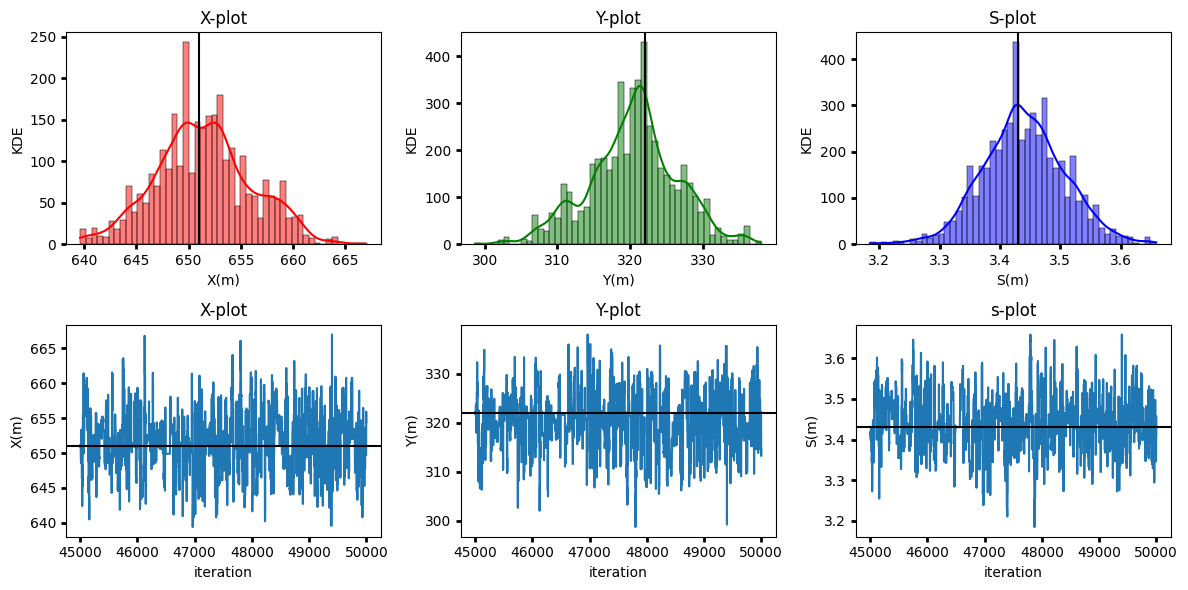

In [33]:
f, ax = plt.subplots(2, 3, figsize = (12, 6))
#直方图统计x
plt.subplot(2,3,1)
sns.histplot(samples[0, -3000:, 0],  bins=50, kde=True, color='red')
# plt.hist(X[-20000:], bins=100 , density=1, facecolor='red')
plt.title('X-plot')
plt.xlabel('X(m)')
plt.ylabel('KDE')
plt.axvline(X_true, color='k')
plt.tick_params(labelsize=10,which='major',width=2,colors='k')
plt.tick_params(labelsize=10,which='minor',width=2,colors='k')

# 直方图统计y
plt.subplot(2,3,2)
# plt.hist(Y[-20000:], bins=100, density=1, facecolor='green')
sns.histplot(samples[0, -5000:, 1], bins=50, kde=True, color='green')
plt.title('Y-plot')
plt.xlabel('Y(m)')
plt.ylabel('KDE')
plt.axvline(Y_true, color='k')
plt.tick_params(labelsize=10,which='major',width=2,colors='k')
plt.tick_params(labelsize=10,which='minor',width=2,colors='k')


# 直方图统计s
plt.subplot(2,3,3)
# plt.hist(Y[-20000:], bins=100, density=1, facecolor='green')
sns.histplot(samples[0, -5000:, 2], bins=50, kde=True, color='blue')
plt.title('S-plot')
plt.xlabel('S(m)')
plt.ylabel('KDE')
plt.axvline(S_true, color='k')
plt.tick_params(labelsize=10,which='major',width=2,colors='k')
plt.tick_params(labelsize=10,which='minor',width=2,colors='k')

#采样值变化x
plt.subplot(2,3,4)
plt.plot(list(range(n_samples-5000, n_samples)), samples[0, -5000:, 0])
plt.title('X-plot')
plt.xlabel('iteration')
plt.ylabel('X(m)')
plt.axhline(X_true, color='k')
plt.tick_params(labelsize=10,which='major',width=2,colors='k')
plt.tick_params(labelsize=10,which='minor',width=2,colors='k')

#采样值变化y
plt.subplot(2,3,5)
plt.plot(list(range(n_samples-5000, n_samples)), samples[0, -5000:, 1])
plt.title('Y-plot')
plt.xlabel('iteration')
plt.ylabel('Y(m)')
plt.axhline(Y_true, color='k')
plt.tick_params(labelsize=10,which='major',width=2,colors='k')
plt.tick_params(labelsize=10,which='minor',width=2,colors='k')

#采样值变化s
plt.subplot(2,3,6)
plt.plot(list(range(n_samples-5000, n_samples)), samples[0, -5000:, 2])
plt.title('s-plot')
plt.xlabel('iteration')
plt.ylabel('S(m)')
plt.axhline(S_true, color='k')
plt.tick_params(labelsize=10,which='major',width=2,colors='k')
plt.tick_params(labelsize=10,which='minor',width=2,colors='k')

plt.tight_layout()
plt.show()

后处理:绘制采样点空间分布

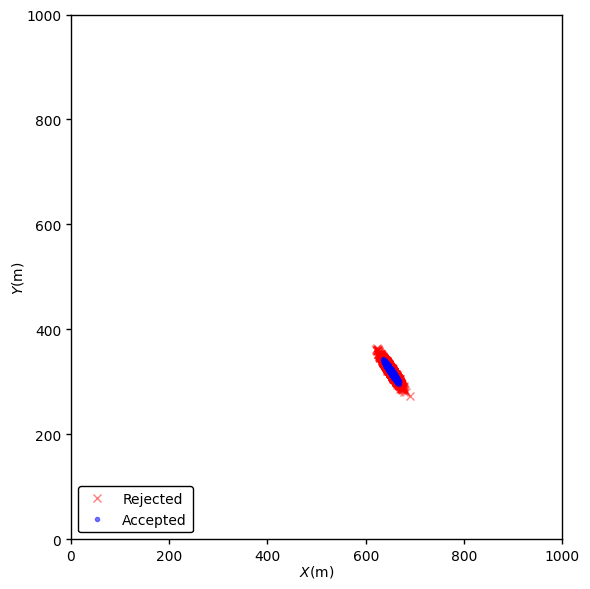

In [16]:
fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(1,1,1)
# ax.plot(accepted[:,0], accepted[:,1], label="Path")
ax.plot(rejected[-5000:,0], rejected[-5000:,1], 'rx', label='Rejected',alpha=0.5)
ax.plot(accepted[-5000:,0], accepted[-5000:,1], 'b.', label='Accepted',alpha=0.5)
plt.xlabel("$X$(m)",labelpad=(0))
plt.ylabel("$Y$(m)",labelpad=(0))
x_major_locator=MultipleLocator(200)
#把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(200)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
#把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)
#把y轴的主刻度设置为1的倍数

ax=plt.gca();#获得坐标轴的句柄
ax.spines['bottom'].set_linewidth(1);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(1);####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(1);###设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(1);####设置上部坐标轴的粗细
ax.xaxis.set_major_formatter('{x:.00f}')
ax.yaxis.set_major_formatter('{x:.00f}')

labels = ax.get_xticklabels() + ax.get_yticklabels()

plt.xlim(0,1000)
plt.ylim(0,1000)

# plt.annotate('$S$', xy=(651,322), weight='heavy', bbox=dict(boxstyle='circle,pad=0.001', fc='yellow', ec='k', lw=1, alpha=1))

plt.tick_params(labelsize=10,which='major',width=1,colors='k')
plt.tick_params(labelsize=10,which='minor',width=1,colors='k')
plt.legend(loc=3,frameon=True, framealpha=1, edgecolor = 'k', prop = {"size":10})
plt.tight_layout()
plt.savefig("transparent_plot.svg", transparent=True)

后处理：绘制坐标采样统计和源强采样统计

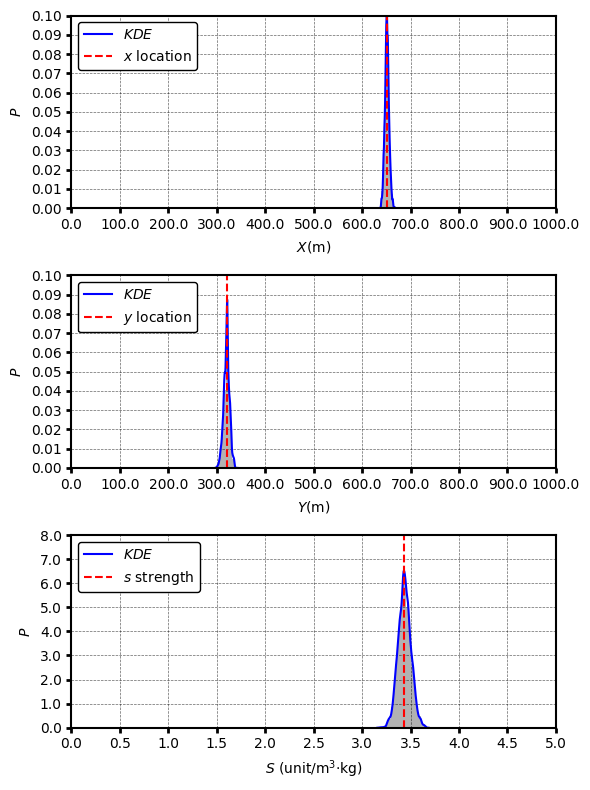

In [22]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

f, ax = plt.subplots(3, 1, figsize = (6, 8))
# 设置字体

#直方图统计X
plt.subplot(3,1,1)
sns.distplot(samples[0, -20000:, 0], hist=True, bins=60, kde=True, fit=None, norm_hist=False,color="b",hist_kws={'alpha':0.6,'color':'gray'},kde_kws={'alpha':1,'color':'blue','linewidth':1.5})
# plt.hist(X_history[-20000:], bins=100)
# sns.kdeplot(X_history[-20000:],shade=True,color="g")
# plt.hist(X[-20000:], bins=100 , density=1, facecolor='red')

plt.xlabel('$X$(m)',labelpad=(5))
plt.ylabel('$P$',labelpad=(5))



plt.tick_params(labelsize=10,which='major',width=2,colors='k')
plt.tick_params(labelsize=10,which='minor',width=2,colors='k')

x_major_locator=MultipleLocator(100)
#把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(0.01)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
#把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)
#把y轴的主刻度设置为1的倍数

ax=plt.gca();#获得坐标轴的句柄
ax.spines['bottom'].set_linewidth(1.5);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(1.5);####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(1.5);###设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(1.5);####设置上部坐标轴的粗细
ax.xaxis.set_major_formatter('{x:.01f}')
ax.yaxis.set_major_formatter('{x:.02f}')

plt.xlim(0,1000)
plt.ylim(0,0.15)
plt.grid(which='both',color='k',linestyle='--', linewidth=0.5,alpha=0.6)
labels = ax.get_xticklabels() + ax.get_yticklabels()
plt.axvline(X_true, color='red',linestyle='--',linewidth=1.5)

plt.legend([r'$KDE$', r'$x$ location'], loc=2,frameon=True, framealpha=1, edgecolor = 'k', prop = {"size":10})
plt.tight_layout()

#  Y采样分布绘图


#直方图统计Y
plt.subplot(3,1,2)
sns.distplot(samples[0, -20000:, 1], hist=True, bins=60, kde=True, fit=None, norm_hist=False,color="b",hist_kws={'alpha':0.6,'color':'gray'},kde_kws={'alpha':1,'color':'blue','linewidth':1.5})
# plt.hist(X_history[-20000:], bins=100)
# sns.kdeplot(X_history[-20000:],shade=True,color="g")
# plt.hist(X[-20000:], bins=100 , density=1, facecolor='red')
plt.xlabel('$Y$(m)',labelpad=(5))
plt.ylabel('$P$',labelpad=(5))
plt.tick_params(labelsize=10,which='major',width=2,colors='k')
plt.tick_params(labelsize=10,which='minor',width=2,colors='k')

x_major_locator=MultipleLocator(100)
#把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(0.01)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
#把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)
#把y轴的主刻度设置为1的倍数

ax=plt.gca();#获得坐标轴的句柄
ax.spines['bottom'].set_linewidth(1.5);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(1.5);####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(1.5);###设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(1.5);####设置上部坐标轴的粗细
ax.xaxis.set_major_formatter('{x:.01f}')
ax.yaxis.set_major_formatter('{x:.02f}')

plt.xlim(0,1000)
plt.ylim(0,0.1)

labels = ax.get_xticklabels() + ax.get_yticklabels()
plt.axvline(Y_true, color='red',linestyle='--',linewidth=1.5)
plt.grid(which='both',color='k',linestyle='--', linewidth=0.5,alpha=0.6)
plt.legend([r'$KDE$', r'$y$ location'], loc=2,frameon=True, framealpha=1, edgecolor = 'k', prop = {"size":10})
plt.tight_layout()

#  S采样分布绘图



#直方图统计S
plt.subplot(3,1,3)
sns.distplot(samples[0, -20000:, 2], hist=True, bins=60, kde=True, fit=None, norm_hist=False,color="b",hist_kws={'alpha':0.6,'color':'gray'},kde_kws={'alpha':1,'color':'blue','linewidth':1.5})
# plt.hist(X_history[-20000:], bins=100)
# sns.kdeplot(X_history[-20000:],shade=True,color="g")
# plt.hist(X[-20000:], bins=100 , density=1, facecolor='red')
plt.xlabel('$S$ ($\mathregular{unit/m^{3}·kg}$)',labelpad=(5))
plt.ylabel('$P$',labelpad=(5))
plt.tick_params(labelsize=10,which='major',width=2,colors='k')
plt.tick_params(labelsize=10,which='minor',width=2,colors='k')

x_major_locator=MultipleLocator(0.5)
#把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(1)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
#把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)
#把y轴的主刻度设置为1的倍数

ax=plt.gca();#获得坐标轴的句柄
ax.spines['bottom'].set_linewidth(1.5);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(1.5);####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(1.5);###设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(1.5);####设置上部坐标轴的粗细
ax.xaxis.set_major_formatter('{x:.01f}')
ax.yaxis.set_major_formatter('{x:.01f}')

plt.xlim(0,5)
plt.ylim(0,8)

labels = ax.get_xticklabels() + ax.get_yticklabels()

plt.axvline(S_true, color='red',linestyle='--',linewidth=1.5)
plt.grid(which='both',color='k',linestyle='--', linewidth=0.5,alpha=0.6)
plt.legend([r'$KDE$', r'$s$ strength'], loc=2, frameon=True, framealpha=1, edgecolor = 'k', prop = {"size":10})
plt.tight_layout()

后处理：显示采样历史

(61715, 3)

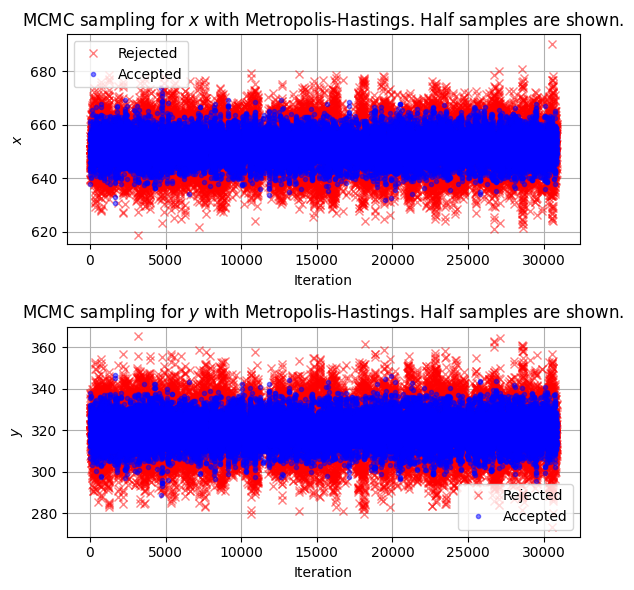

In [26]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(2,1,1)
to_show=-int(0.5*accepted.shape[0])
ax.plot( rejected[to_show:, 0], 'rx', label='Rejected',alpha=0.5)
ax.plot( accepted[to_show:, 0], 'b.', label='Accepted',alpha=0.5)
ax.set_xlabel("Iteration")
ax.set_ylabel("$x$")
ax.set_title("MCMC sampling for $x$ with Metropolis-Hastings. Half samples are shown.")
ax.grid()
ax.legend()

ax2 = fig.add_subplot(2,1,2)
to_show=-int(0.5*accepted.shape[0])
ax2.plot( rejected[to_show:, 1], 'rx', label='Rejected',alpha=0.5)
ax2.plot( accepted[to_show:, 1], 'b.', label='Accepted',alpha=0.5)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("$y$")
ax2.set_title("MCMC sampling for $y$ with Metropolis-Hastings. Half samples are shown.")
ax2.grid()
ax2.legend()

fig.tight_layout()
accepted.shape


后处理：显示自相关性

计算各被接收的采样点之间的自相关系数可以确定马尔可夫链是否达到收敛（即当前状态只与上一个状态相关，而与之前的状态无关）和确定建议分布中高斯分布的方差选取是否合适


$${\rho _k} = {{Cov({M_i},{M_{avg}})} \over {\sqrt {D(M)} \sqrt {D({M_{avg}})} }} = {{\mathop \sum \nolimits_{i = 1}^{N - k} ({M_i} - {M_{avg}})({M_{i + k}} - {M_{avg}})} \over {\mathop \sum \nolimits_{i = 1}^N {{({M_i} - {M_{avg}})}^2}}}$$

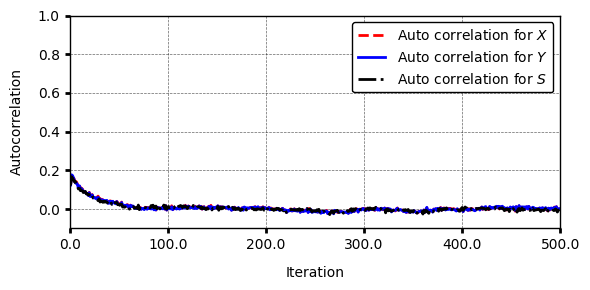

In [27]:
show=-int(0.5*accepted.shape[0])
mean_acc_0=accepted[show:,0].mean()
mean_acc_1=accepted[show:,1].mean()
mean_acc_2=accepted[show:,2].mean()
lag=np.arange(1,500)

def autocorr(accepted,lag):
    num_0=0
    denom_0=0
    num_1=0
    denom_1=0
    num_2=0
    denom_2=0
    for i in range(accepted.shape[0]-lag):
        num_0+=(accepted[i,0]-mean_acc_0)*(accepted[i+lag,0]-mean_acc_0)
        num_1+=(accepted[i,1]-mean_acc_1)*(accepted[i+lag,1]-mean_acc_1)
        num_2+=(accepted[i,2]-mean_acc_2)*(accepted[i+lag,2]-mean_acc_2)
        denom_0+=(mean_acc_0-accepted[i,0])**2
        denom_1+=(mean_acc_1-accepted[i,1])**2
        denom_2+=(mean_acc_2-accepted[i,2])**2
    rk_0=num_0/denom_0
    rk_1=num_1/denom_1
    rk_2=num_2/denom_2  
    return rk_0, rk_1, rk_2


accepted_reversed=accepted[show:,:]
result=np.zeros((3,lag.shape[0]))
#print(lag)
for l in lag:
    result[:,l-1]=autocorr(accepted_reversed,l)
    
    
###Instead of writing an autocorrelation function, one could simply use thee autocorr function provided in pymc3    
#from pymc3.stats import autocorr
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(1,1,1)
#ax.plot(lag, [autocorr(accepted[show:,1], l) for l in lags], label='auto b')
#ax.plot(lag, [autocorr(accepted[show:,0], l) for l in lags], label='auto a')
ax.plot(lag, result[1,:], linestyle='--',color='r', linewidth=2, label='Auto correlation for $X$')
ax.plot(lag, result[0,:], linestyle='-', color='b',linewidth=2, label='Auto correlation for $Y$')
ax.plot(lag, result[2,:], linestyle='-.',color='k', linewidth=2, label='Auto correlation for $S$')
ax.legend(loc=0)

plt.xlabel("Iteration",labelpad=(10))
plt.ylabel("Autocorrelation",labelpad=(10))
x_major_locator=MultipleLocator(100)
#把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(0.2)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
#把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)
#把y轴的主刻度设置为1的倍数

ax=plt.gca();#获得坐标轴的句柄
ax.spines['bottom'].set_linewidth(1);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(1);####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(1);###设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(1);####设置上部坐标轴的粗细
ax.xaxis.set_major_formatter('{x:.01f}')
ax.yaxis.set_major_formatter('{x:.01f}')

plt.xlim(0,500)
plt.ylim(-0.1,1)

plt.grid(which='both',color='k',linestyle='--', linewidth=0.5,alpha=0.6)

labels = ax.get_xticklabels() + ax.get_yticklabels()

plt.tick_params(labelsize=10,which='major',width=2,colors='k')
plt.tick_params(labelsize=10,which='minor',width=2,colors='k')
plt.legend(loc=1,frameon=True, framealpha=1, edgecolor = 'k', prop = {"size":10})
plt.tight_layout()

# 5. 后续和不足<a id='layer5'></a>

1. 作为一种新型算法需要做更多场景的鲁棒性测试
2. 本文仅介绍该算法是实现及后处理过程，与现有算法的对比并未涉及
3. 文中用了大量数组，代码执行效率有很大优化空间